# Lekce 7

## Regrese

Samotná informace o tom, že existuje statisticky významný vztah mezi obytnou plochou domu a jeho cenou, sice může být zajímavá, ale můžeme zjistit více. K tomu můžeme využít regresi. Regrese je nástroj, který umí vztah mezi dvěma proměnnými popsat. Abychom si pod slovem "popsat" dokázali něco představit, využijeme graf. Využijeme opět modul `seaborn`, tentokrát vygenerujeme graf pomocí funkce `regplot()`. U regrese vždy rozlušujeme mezi **závislou** (**vysvětlovanou**) a **nezávislou** (**vysvětlující**) proměnnou. Závislou proměnnou umísťujeme na svislou osu (*y*) a nezávislou vodorovnou osu (*x*). V našem případě je nezávislou proměnnou obytná plocha domu a závislou proměnnou cena. Tvrdíme totiž, že obytná plocha domu ovlivňuje cenu, tj. cenu vysvětlujeme pomocí obytné plochy.

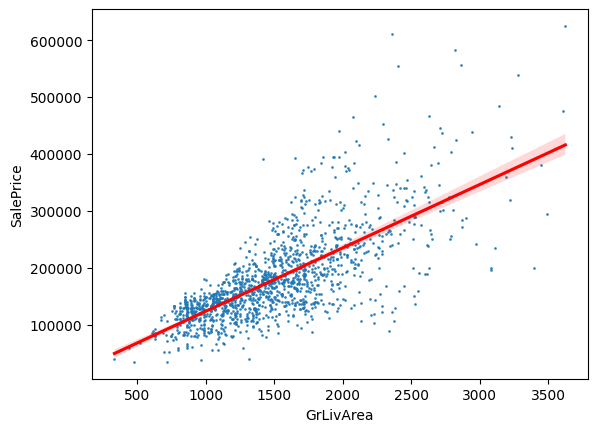

In [230]:
import pandas
import seaborn
import matplotlib.pyplot as plt

data = pandas.read_csv("house_prices.csv")
g = seaborn.regplot(data, x="GrLivArea", y="SalePrice", scatter_kws={"s": 1}, line_kws={"color":"r"})

V datech vidíme velké množství tzv. odlehlých pozorování (outliers). V řadě případů se taková pozorování odebírají, protože mají na regresní funkci negativní vliv. Jak ale rozpoznat odlehlné pozorování? Existuje řada způsobů, jak odlehlá pozorování odebrat. Jedna z nejjenodušších metod je z-score, které je počítáno dle vzorce *(x - průměr) / směrodatná odchylka*.

Uvažujme následující případ. Máme průměr hodnot 5 a směrodatnou odchylku 2. Pokud je nějaká hodnota 6, je její z-score 0.5. Pro hodnotu 1 je z-score - 2. Hodnota 6 je tedy méně odlehlá než hodnota 1. Hodnota z-score, od které budeme pozorování odebírat, může být například 2 nebo 3. Samozřejmě uvažujeme absolutní hodnotu vypočteného z-score, kterou můžeme získat pomocí modulu `numpy`.

Na grafu níže je vidět, že nejvíce odlehlá pozorování byla odebrána.

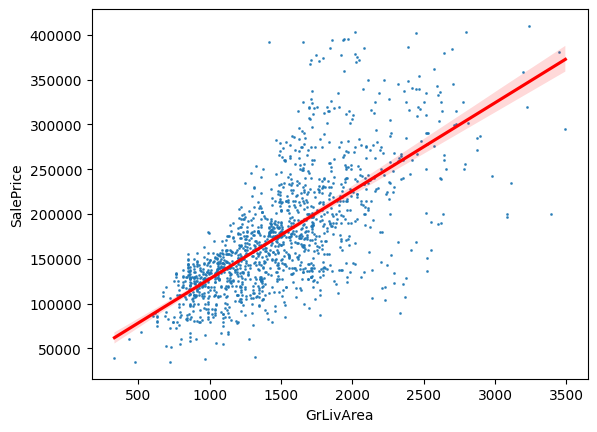

In [231]:
from scipy import stats
import numpy

data["SalePriceZScore"] = numpy.abs(stats.zscore(data['SalePrice']))
data = data[data["SalePriceZScore"] < 3]
g = seaborn.regplot(data, x="GrLivArea", y="SalePrice", scatter_kws={"s": 1}, line_kws={"color":"r"})

Pojďme nyní provést výpočet regresního modelu. Výsledky zobrazíme v tabulce `OLS Regression Results`.

Tabulka je velmi rozsáhlá a my si vysvětlíme hlavní hodnoty, které nás zajímají.

Hlavní jsou hodnoty regresních koeficientů - `Intercept` a `GrLivArea`.

- `Intercept` je kontanta. Teoreticky nám říká, kolik by stál dům o nulové velikosti (což je samozřejmě v praxi nesmysl). Geometricky řečeno, pokud bychom protáhli červenou čáru, tento koeficient nám říká, kde by čára protla osu *y* (svislou osu).
- `GrLivArea` udává sklon čáry. Čím je koeficient vyšší, tím více si musíme připlatit za každou další čtvereční stopu. 

U nepřímých závislostí je koeficient u vysvětlující proměnné záporný (např. venkovní teplota a spotřeba energie na vytápění - čím je teplejší počasí, tím méně topíme, za každý stupeň nahoru klesně spotřeba o 100 kW).

In [232]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

formula = "SalePrice ~ GrLivArea"
mod = smf.ols(formula=formula, data=data)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.487
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     1357.
Date:                Sun, 14 May 2023   Prob (F-statistic):          1.39e-209
Time:                        17:36:49   Log-Likelihood:                -17491.
No. Observations:                1434   AIC:                         3.499e+04
Df Residuals:                    1432   BIC:                         3.500e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.911e+04   4171.056      6.979      0.000    2.09e+04    3.73e+04
GrLivArea     98.3600      2.670     36.844      0.000      93.123     103.597
==============================================================================
Omnibus:                      131.107   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              330.277
Skew:                           0.514   Prob(JB):                     1.91e-72
Kurtosis:                       5.114   Cond. No.                     5.14e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.14e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Jak ale program na tyto koeficienty přišel?

Přidejme si do tabulky `data` dva sloupce:

- `fittedvalues` (vyrovnané hodnoty) jsou hodnoty odhadované modelem, tj. cena domu, kterou by predikoval náš model na základě jeho velikosti,
- `resid` (rezidua) je rozdíl mezi skutečnou cenou domu a predikovanou cenou.

Regrese funguje na principu minimalizace druhé mocniny součtu reziduí. Tj. vypočtené koeficienti minimalizují druhou mocninu součtu reziduí.

In [233]:
data["residuals"] = res.resid
data["predictions"] = res.fittedvalues
data[["GrLivArea", "SalePrice", "predictions", "residuals"]]

,GrLivArea,SalePrice,predictions,residuals
0,1710,208500,197305.936099,11194.063901
1,1262,181500,153240.661054,28259.338946
2,1786,223500,204781.295259,18718.704741
3,1717,140000,197994.456022,-57994.456022
4,2198,250000,245305.610702,4694.389298
...,...,...,...,...
1451,1647,175000,191109.256796,-16109.256796
1452,2073,210000,233010.612085,-23010.612085
1453,2340,266500,259272.729132,7227.270868
1454,1078,142125,135142.423089,6982.576911


Pro regresi je dále důležité, aby rezidua měla normální rozdělení. Pro testování normality je možné využít standardní testy, modul `statsmodels` nám nabízí výsledky dvou testů: Omnibus testu a Jarque-Bera testu. Oba fungují na základě tvaru distribuční funice - šikmosti (jak moc je hustota symetrická) a špičatosti (jak rychle hustota od středu klesá). Poskytnuté p-hodnoty (ty jsou vždy označené jako `Prob.`) jsou v obou případech menší než 0.05, zamítáme tedy hypotézu normality reziduí.

<Axes: ylabel='Density'>

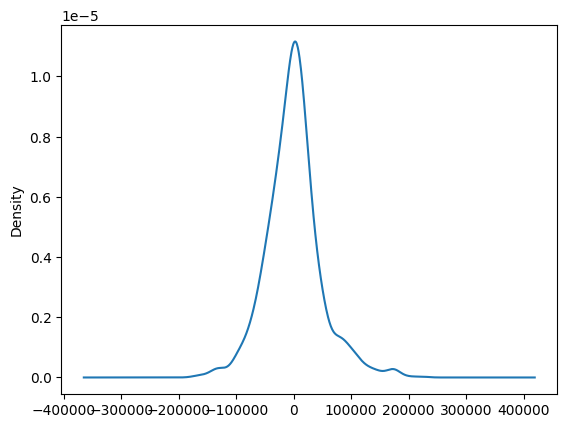

In [234]:
data["residuals"].plot.kde()

<Axes: ylabel='Count'>

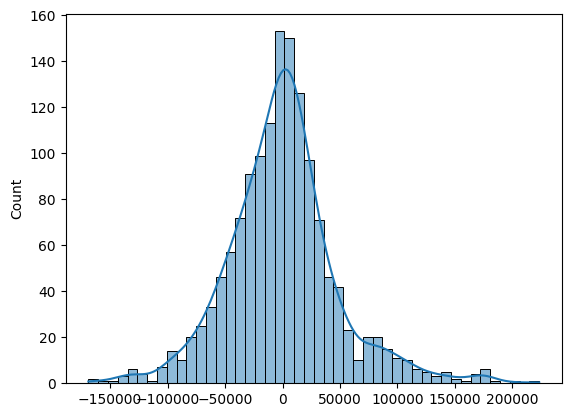

In [235]:
import seaborn
seaborn.histplot(res.resid, kde=True)

Pokud rezidua nejsou normální, můžeme zkusit provést úpravu vysvětlované proměnné. Takovou úpravu nazýváme transformací. Existuje řada transformací, můžeme vyzkoušet například logaritmickou transformaci. V takovém případě nahradíme původní ceny logaritmy cen.

Více o logaritmické transformaci se dozvíš ve videu [zde](https://youtu.be/1DON1XgYM4A).

In [236]:
import numpy

data = pandas.read_csv("house_prices.csv")

data["lnSalePrice"] = numpy.log(data["SalePrice"])
data[["SalePrice", "lnSalePrice"]]

,SalePrice,lnSalePrice
0,208500,12.247694
1,181500,12.109011
2,223500,12.317167
3,140000,11.849398
4,250000,12.429216
...,...,...
1451,175000,12.072541
1452,210000,12.254863
1453,266500,12.493130
1454,142125,11.864462


Spočítáme nyní model znovu.

In [237]:
formula = "lnSalePrice ~ GrLivArea"
mod = smf.ols(formula=formula, data=data)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            lnSalePrice   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                     1555.
Date:                Sun, 14 May 2023   Prob (F-statistic):          7.33e-232
Time:                        17:36:51   Log-Likelihood:                -187.62
No. Observations:                1456   AIC:                             379.2
Df Residuals:                    1454   BIC:                             389.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.1586      0.023    483.993      0.000      11.113      11.204
GrLivArea      0.0006   1.45e-05     39.430      0.000       0.001       0.001
==============================================================================
Omnibus:                      108.360   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              179.482
Skew:                          -0.550   Prob(JB):                     1.06e-39
Kurtosis:                       4.322   Cond. No.                     5.07e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.07e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Ani v tomto případě nejsou rezidua normální.

Normalita reziudí nám brání v použití řady údajů, které nám modul vypočítal. Pokud by rezidua byla normální, mohli bychom interpretovat následující údaje:

- `F-statistic` - testuje hypotézu, zda je model statisticky významný jako celek. To oceníme hlavně v případě modelu s více proměnnými. Pokud by byla p-hodnota více než 0.05, je model statisticky nevýznamný (tj. nic nám neříká).
- `P>|t|` - testuje hypotézu, zda je statisticky významný konkrétní koeficient. Test se tedy počítá pro každý koeficient zvlášť. Pokud by byla p-hodnota více než 0.05, je koeficient statisticky nevýznamný.

Použít ale můžeme základní měřítko kvality modelu, což je koeficient determinace `R-squared`. Ten nám říká, kolik procet rozptylu vysvětlované proměnné jsme naším modelem vysvětlili.

Více informací najdete například v [tomto článku](https://medium.com/swlh/interpreting-linear-regression-through-statsmodels-summary-4796d359035a).

### Robustní regrese

V případě odlehlých pozorování a porušení normality je možné využít i robustní regresi. Ta přiřazuje odlehlejším pozorováním nižší váhu, tj. odlehlá pozorování nám tolik nevychýlí regresní funkci.

Přehled různých metod, jak snížit váhu koeficientů, jsou [zde](https://www.statsmodels.org/dev/examples/notebooks/generated/robust_models_1.html).

In [238]:
data = pandas.read_csv("house_prices.csv")

data_x = data["GrLivArea"].to_frame()
data_x = sm.add_constant(data_x)

rlm_model = sm.RLM(data["SalePrice"], data_x)
rlm_results = rlm_model.fit()
rlm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:              SalePrice   No. Observations:                 1456
Model:                            RLM   Df Residuals:                     1454
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 14 May 2023                                         
Time:                        17:36:51                                         
No. Iterations:                     3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.815e+04   3541.705      5.124      0.000    1.12e+04    2.51e+04
GrLivArea    105.7028      2.233     47.342      0.000     101.327     110.079
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [239]:
sum(numpy.abs(rlm_results.resid))

53571953.881708235

In [240]:
data_x = data[["GrLivArea", "GarageArea"]]
data_x = sm.add_constant(data_x)

rlm_model = sm.RLM(data["SalePrice"], data_x)
rlm_results = rlm_model.fit()
rlm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:              SalePrice   No. Observations:                 1456
Model:                            RLM   Df Residuals:                     1453
Method:                          IRLS   Df Model:                            2
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 14 May 2023                                         
Time:                        17:36:51                                         
No. Iterations:                     5                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2247.0002   3125.948     -0.719      0.472   -8373.747    3879.746
GrLivArea     79.1223      2.120     37.313      0.000      74.966      83.278
GarageArea   130.0671      4.970     26.173      0.000     120.327     139.807
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [241]:
sum(numpy.abs(rlm_results.resid))

45903817.07842432

# Cvičení

## Kvalita betonu

V souboru [Concrete_Data_Yeh.csv](Concrete_Data_Yeh.csv) najdeš informace o kvalitě betonu. Sloupce 1-7 udávají množství jednotlivých složek v kg, které byly přimíchány do krychlového metru betonu (např. cement, voda, kamenivo, písek atd.). Ve sloupci 8 je stáří betonu a ve sloupci 9 kompresní síla betonu v megapascalech. Vytvoř regresní model, který bude predikovat kompresní sílu betonu na základě všech množství jednotlivých složek a jeho stáří. Zhodnoť kvalitu modelu.

Která ze složek betonu ovlivňuje sílu betonu negativně (tj. má záporný regresní koeficient)?

```py
formula = "csMPa ~ slag + flyash"
```

Řešení příkladu je [zde](reseni.ipynb). Video s řešením příkladu je [zde](https://youtu.be/iGXlEpf0yb4).

## Bonus: Pojišťovna

V souboru [expenses.csv](expenses.csv) najdeš informace o platbách za pojištěnce jedné pojišťovny: věk, pohlaví, BMI (index počítaný jako hmotnost dělená výškou), počet dětí, kuřák/nekuřák, region a platby za pojištěnce. 

Vytvoř regresní model, který odhadne platby za pojištěnce na základě jeho věku a indexu BMI.

V regresi se často využívá metoda označovaná jako One Hot Encoding, která slouží ke zpracování nečíselných (kategoriálních) dat. Metodu aplikuješ tak, že vytvoříme sloupec pro každou hodnotu, které kategoriálních hodnota může nabýt. Pro každý řádek je pak hodnota příslušného sloupce 1 a ostatních sloupců 0. Vytvoř tedy sloupec `smoker_number` (takovému sloupci se říká *dummy* proměnná), který bude obsahovat hodnotu 1, pokud je ve sloupci `smoker` hodnota `yes`, a v opačném případě 0. Můžeš využít metodu `apply()` nebo funkci `numpy.where()`. Dále přidej nově vytvořený sloupec do regresního modelu. O kolik se zvýšil koeficient determinace?

Takový postup vytváření je poměrně pracný, hlavně v případě, že proměnná nabývá více různých hodnot. `pandas` k tomu nabízí funkci `get_dummies()`. Vyzkoušej si funkci použitím příkazu níže.

```py
smoker = pandas.get_dummies(data["smoker"])
smoker
```

Dále připoj data do původní tabulky. Připojení je nutné provést s využitím indexů, protože tabulky nemají společný sloupec. Proto využij funkci `merge()` s parametry `left_index=True` a `right_index=True`.

```py
data = pandas.merge(data, smoker, left_index=True, right_index=True)
data
```

Nyní využij tento sloupec ve svém regresním modelu.

Řešení bonusu je [zde](reseni.ipynb). Video s řešením příkladu je [zde](https://youtu.be/oJPz7Ui4ZkE).